In [1]:
import pickle
import numpy as np
import torch
from torch_geometric.data import Data
import matplotlib.tri as mtric

In [2]:
from scipy.spatial import Delaunay

In [3]:
def read_pickle(keys, path="./"):
    data_dict = {}
    for key in keys:
        with open(path+key+".pkl", "rb") as f:
            data_dict[key] = pickle.load(f)
    return data_dict

In [4]:
def neighbors_from_delaunay(tri):
    """Returns ndarray of shape (N, *) with indices of neigbors for each node.
    N is the number of nodes.
    """
    neighbors_tri = tri.vertex_neighbor_vertices
    neighbors = []
    for i in range(len(neighbors_tri[0])-1):
        curr_node_neighbors = []
        for j in range(neighbors_tri[0][i], neighbors_tri[0][i+1]):
            curr_node_neighbors.append(neighbors_tri[1][j])
        neighbors.append(curr_node_neighbors)
    return neighbors

In [5]:
def is_near(x, y, eps=1.0e-16):
    x = np.array(x)
    y = np.array(y)
    for yi in y:
        if np.linalg.norm(x - yi) < eps:
            return True
    return False

In [6]:
def generate_torchgeom_dataset(data):
    """Returns dataset that can be used to train our model.
    
    Args:
        data (dict): Data dictionary with keys t, x, u.
    Returns:
        dataset (list): Array of torchgeometric Data objects.
    """

    n_sims = data['u'].shape[0]
    dataset = []

    for sim_ind in range(n_sims):
        print("{} / {}".format(sim_ind+1, n_sims))
        
        x = data['x'][sim_ind]
        tri = Delaunay(x)
        neighbors = neighbors_from_delaunay(tri)

        # Find periodic couples and merge their neighborhoods
        origin_node = 0
        corner_nodes = []
        hor_couples = []
        vert_couples = []
        eps = 1.0e-6

        b = x.ravel().max()  # domain size

        for i in range(x.shape[0]):
            if is_near(x[i], [[b, 0], [0, b], [b, b]]):
                corner_nodes.append(i)
            elif is_near(x[i], [[0, 0]]):
                origin_node = i
            elif abs(x[i, 0]) < eps:  # left boundary
                for j in range(x.shape[0]):
                    if abs(x[j, 0] - b) < eps and abs(x[j, 1] - x[i, 1]) < eps:
                        hor_couples.append([i, j])
            elif abs(x[i, 1]) < eps:  # bottom boundary
                for j in range(x.shape[0]):
                    if abs(x[j, 1] - b) < eps and abs(x[j, 0] - x[i, 0]) < eps:
                        vert_couples.append([i, j])

        remove_nodes = []

        # Merge corners
        for i in corner_nodes:
            neighbors[origin_node].extend(neighbors[i])
            remove_nodes.append(i)

        # Merge horizontal couples
        for i, j in hor_couples:
            neighbors[i].extend(neighbors[j])
            remove_nodes.append(j)

        # Merge vertical couples
        for i, j in vert_couples:
            neighbors[i].extend(neighbors[j])
            remove_nodes.append(j)

        use_nodes = list(set(range(len(x))) - set(remove_nodes))

        # Remove right and top boundaries
        neighbors = np.array(neighbors, dtype=np.object)[use_nodes]

        # Rewrite indices of the removed nodes
        map_domain = corner_nodes + [x[1] for x in hor_couples] + [x[1] for x in vert_couples]
        map_codomain = [origin_node]*3 + [x[0] for x in hor_couples] + [x[0] for x in vert_couples]
        map_inds = dict(zip(map_domain, map_codomain))

        for i in range(len(neighbors)):
            for j in range(len(neighbors[i])):
                if neighbors[i][j] in remove_nodes:
                    neighbors[i][j] = map_inds[neighbors[i][j]]
            neighbors[i] = list(set(neighbors[i]))  # remove duplicates

        # Reset indices
        map_inds = dict(zip(use_nodes, range(len(use_nodes))))

        for i in range(len(neighbors)):
            for j in range(len(neighbors[i])):
                neighbors[i][j] = map_inds[neighbors[i][j]]

        # ...
        edge_index = []
        for i, _ in enumerate(neighbors):
            for _, neighbor in enumerate(neighbors[i]):
                if i == neighbor:
                    continue
                edge = [i, neighbor]
                edge_index.append(edge)
        edge_index = np.array(edge_index).T

        # coords_use = data['x'][sim_ind, use_nodes]
        # coords_rem = data['x'][sim_ind, remove_nodes]
        # plt.scatter(coords_use[:, 0], coords_use[:, 1], s=3)
        # plt.scatter(coords_rem[:, 0], coords_rem[:, 1], s=3)
        # plt.savefig("tmp.png")
        # print(qwe)
        
        n = None
        print(f"generate_torchgeom_dataset() -> using {n} steps.")
        tg_data = Data(
            x=torch.Tensor(data['u'][sim_ind, 0, use_nodes, :]),
            edge_index=torch.Tensor(edge_index).long(),
            y=torch.Tensor(data['u'][sim_ind][0:n, use_nodes]).transpose(0, 1),
            pos=torch.Tensor(data['x'][sim_ind, use_nodes]),
            t=torch.Tensor(data['t'][sim_ind][0:n]),
        )
        
        dataset.append(tg_data)

    return dataset

In [7]:
def get_parameters_count(model):
    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return n_params

In [8]:
def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data, gain=1.66666667)
        torch.nn.init.zeros_(m.bias.data)


In [9]:
def get_warmup_scheduler(a):
    def scheduler(epoch):
        if epoch <= a:
            return epoch * 1.0 / a
        else:
            return 1.0
    return scheduler


In [10]:
def plot_graph(coords):
    tri = Delaunay(coords)
    plt.triplot(coords[:, 0], coords[:, 1], tri.simplices.copy())
    plt.plot(coords[:, 0], coords[:, 1], 'o')
    plt.hlines(0, 0, 1)
    plt.hlines(1, 0, 1)
    plt.vlines(0, 0, 1)
    plt.vlines(1, 0, 1)


In [11]:
def plot_triang_grid(ax, coords, values):
    x = coords[:, 0]
    y = coords[:, 1]
    triang = mtri.Triangulation(x, y)
    levels = np.linspace(0.0, 5.0, 31)
    im = ax.tricontourf(triang, values, levels=levels)  # norm=mpl.colors.Normalize(vmin=-0.5, vmax=1.5)
    # ax.triplot(triang, 'ko-', linewidth=0.1, ms=0.5)
    return im

In [12]:
def plot_grid(coords):
    x = coords[:, 0]
    y = coords[:, 1]
    triang = mtri.Triangulation(x, y)
    plt.triplot(triang, 'ko-', linewidth=0.1, ms=0.5)
    plt.savefig("grid.png")


In [13]:
def plot_fields(t, coords, fields, delay=0.1, save_path=None):
    """
    Args:
        t (ndarray): Time points.
        coords (ndarray): Coordinates of nodes.
        fields (dict): keys - field names.
            values - ndarrays with shape (time, num_nodes, 1).
        save_path (str): Path where plot will be saved as save_path/field_name_time.png
    """
    num_fields = len(fields.keys())

    fig, ax = plt.subplots(1, num_fields, figsize=(6*num_fields, 6))
    if num_fields == 1:
        ax = [ax]
    else:
        ax = ax.reshape(-1)

    mappables = [
        plot_triang_grid(
            ax[i], coords,
            fields[list(fields.keys())[i]][0].squeeze()) for i in range(num_fields)]
    [fig.colorbar(im, ax=ax) for im in mappables]

    plt.show(block=False)

    for j, tj in enumerate(t):
        for i, (key, field) in enumerate(fields.items()):
            ax[i].cla()
            mappables[i] = plot_triang_grid(ax[i], coords, field[j].squeeze())
            ax[i].set_aspect('equal')
            ax[i].set_title("Field {:s} at time {:.6f}".format(key, tj))
            
        if save_path is not None:
            plt.savefig(save_path+"{:d}.png".format(j))

        plt.draw()
        plt.pause(delay)

In [14]:
import numpy as np
from collections import namedtuple

import torch
import torch.nn as nn
import torch.optim as optim

In [15]:
from torchdiffeq import odeint_adjoint as odeint

In [16]:
from torch_geometric.nn import MessagePassing


class Model(MessagePassing):
    def __init__(self, gamma, phi):
        super(Model, self).__init__(aggr='mean', flow='target_to_source')
        self.gamma = gamma
        self.phi = phi

    def forward(self, u, edge_index, rel_pos):
        return self.propagate(edge_index, u=u, rel_pos=rel_pos)

    def message(self, u_i, u_j, rel_pos):
        phi_input = torch.cat([u_i, u_j-u_i, rel_pos], dim=1)
        return self.phi(phi_input)

    def update(self, aggr, u):
        gamma_input = torch.cat([u, aggr], dim=1)
        dudt = self.gamma(gamma_input)
        return dudt

In [17]:
class ModelDirichlet(Model):
    def forward(self, u, edge_index, rel_pos, bcs_dict):
        return self.propagate(edge_index, u=u, rel_pos=rel_pos, bcs_dict=bcs_dict)
    
    def update(self, aggr, u, bcs_dict):
        dudt = super().update(aggr, u)
        for bc_inds, field_inds in bcs_dict.values():
            dudt[bc_inds, field_inds] *= 0  
        return dudt

In [18]:
class DynamicsFunction(nn.Module):
    def __init__(self, model, params=None):
        super().__init__()
        self.model = model
        if params is None:
            self.params = {}
        else:
            self.params = params
    
    def forward(self, t, u):
        return self.model(u, **self.params)

    def update_params(self, params):
        self.params.update(params)

In [19]:
# Can be replaced by argparse
Config = namedtuple(
    "Config", 
    [
        "d", "hs_1", "hs_2", "method", "rtol", 
        "atol", "device", "batch_size", "lr", 
        "epochs", "model_path", "data_path",
        "tb_log_dir",
    ]
)

args = Config(
    d=40,  # 40
    hs_1=60,  # 60
    hs_2=0,
    method="adaptive_heun",  # adams
    rtol=0.0,
    atol=1.0e-5,
    device="cuda",
    batch_size=None,  # Use None for full batch
    lr=0.000001,
    epochs=200,
    model_path="./models/model_tmp.pth",
    data_path="./data/burgers/burgers_periodic_2pi_train/",
    tb_log_dir="./tb_logs/",
)

print(args)
device = torch.device(args.device)
# writer = SummaryWriter(log_dir=args.tb_log_dir)

# Create model
msg_net = nn.Sequential(
    nn.Linear(6, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.d)
)
aggr_net = nn.Sequential(
    nn.Linear(args.d+2, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, 2)
)

model = Model(aggr_net, msg_net)
model.apply(weights_init)
F = DynamicsFunction(model).to(device)
# F.load_state_dict(torch.load("./model_tmp_pretr_10.pth", map_location=device))

print("Num. of params: {:d}".format(get_parameters_count(model)))


Config(d=40, hs_1=60, hs_2=0, method='adaptive_heun', rtol=0.0, atol=1e-05, device='cuda', batch_size=None, lr=1e-06, epochs=200, model_path='./models/model_tmp.pth', data_path='./data/burgers/burgers_periodic_2pi_train/', tb_log_dir='./tb_logs/')
Num. of params: 20202


In [20]:
data = read_pickle(['t', 'x', 'u'], args.data_path)
dataset = generate_torchgeom_dataset(data)
if args.batch_size is None:
    batch_size = len(dataset)
else:
    batch_size = args.batch_size

print(dataset)

1 / 8


/home/wangyaohong/.conda/envs/pytorch1.6/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


generate_torchgeom_dataset() -> using None steps.
2 / 8
generate_torchgeom_dataset() -> using None steps.
3 / 8
generate_torchgeom_dataset() -> using None steps.
4 / 8
generate_torchgeom_dataset() -> using None steps.
5 / 8
generate_torchgeom_dataset() -> using None steps.
6 / 8
generate_torchgeom_dataset() -> using None steps.
7 / 8
generate_torchgeom_dataset() -> using None steps.
8 / 8
generate_torchgeom_dataset() -> using None steps.
[Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[5266, 2], t=[21]), Data(x=[5266, 2], edge_index=[2, 31596], y=[5266, 21, 2], pos=[52

In [21]:
from torch_geometric.data import DataLoader


In [22]:
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = optim.Rprop(F.parameters(), lr=args.lr, step_sizes=(1e-8, 10.))
loss_fn = nn.MSELoss()


/home/wangyaohong/.conda/envs/pytorch1.6/lib/python3.7/site-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [23]:
# Training
ts = dataset[0].t.shape[0]  # assumes the same time grid for all sim-s.
print(dataset[0].t)

for epoch in range(args.epochs):
    losses = torch.zeros(len(loader))
    
    for i, dp in enumerate(loader):
        optimizer.zero_grad()

        edge_index = dp.edge_index
        pos = dp.pos
        with torch.no_grad():
            rel_pos = pos[edge_index[1]] - pos[edge_index[0]]
        params_dict = {'edge_index': edge_index.to(device), 'rel_pos': rel_pos.to(device)}
        F.update_params(params_dict)

        options = {
            'dtype': torch.float64,
            # 'first_step': 1.0e-9,
            # 'grid_points': t,
        }

        adjoint_options = {
            'norm': "seminorm"
        }

        y0 = dp.x.to(device)
        t = dp.t[0:ts].to(device)
        y_pd = odeint(
            F, y0, t, method=args.method, 
            rtol=args.rtol, atol=args.atol,
            options=options,
            adjoint_options=adjoint_options,
        )
        y_gt = dp.y.transpose(0, 1).to(device)

        loss = loss_fn(y_pd, y_gt.to(device))
        loss.backward()
        optimizer.step()

        losses[i] = loss.item()
        
    # writer.add_scalar("train_loss/"+str(args), losses.mean(), epoch)
    
    if epoch % 10 == 0 or epoch == args.epochs - 1:
        print("epoch {:>5d} | train loss: {:>7.12f}".format(epoch, losses.mean()))
        torch.save(F.state_dict(), args.model_path)

tensor([0.0000, 0.0400, 0.0800, 0.1200, 0.1600, 0.2000, 0.2400, 0.2800, 0.3200,
        0.3600, 0.4000, 0.4400, 0.4800, 0.5200, 0.5600, 0.6000, 0.6400, 0.6800,
        0.7200, 0.7600, 0.8000])


/home/wangyaohong/.conda/envs/pytorch1.6/lib/python3.7/site-packages/torchdiffeq/_impl/misc.py:326: UserWarning: torch.nextafter is only available in PyTorch 1.7 or newer.Falling back to numpy.nextafter. Upgrade PyTorch to remove this warning.
  warnings.warn("torch.nextafter is only available in PyTorch 1.7 or newer."


epoch     0 | train loss: 0.782786607742
epoch    10 | train loss: 0.772524297237
epoch    20 | train loss: 0.711356639862
epoch    30 | train loss: 0.443260878325
epoch    40 | train loss: 0.303548812866
epoch    50 | train loss: 0.282309770584
epoch    60 | train loss: 0.258526653051
epoch    70 | train loss: 0.189707487822
epoch    80 | train loss: 0.092403016984
epoch    90 | train loss: 0.061391919851
epoch   100 | train loss: 0.046400602907
epoch   110 | train loss: 0.037789337337
epoch   120 | train loss: 0.030376924202
epoch   130 | train loss: 0.025047976524
epoch   140 | train loss: 0.020711798221
epoch   150 | train loss: 0.017782911658
epoch   160 | train loss: 0.015480967239
epoch   170 | train loss: 0.013665401377
epoch   180 | train loss: 0.012291011401
epoch   190 | train loss: 0.011028414592
epoch   199 | train loss: 0.010093293153


1 / 10


/home/wangyaohong/.conda/envs/pytorch1.6/lib/python3.7/site-packages/ipykernel_launcher.py:63: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


generate_torchgeom_dataset() -> using None steps.
2 / 10
generate_torchgeom_dataset() -> using None steps.
3 / 10
generate_torchgeom_dataset() -> using None steps.
4 / 10
generate_torchgeom_dataset() -> using None steps.
5 / 10
generate_torchgeom_dataset() -> using None steps.
6 / 10
generate_torchgeom_dataset() -> using None steps.
7 / 10
generate_torchgeom_dataset() -> using None steps.
8 / 10
generate_torchgeom_dataset() -> using None steps.
9 / 10
generate_torchgeom_dataset() -> using None steps.
10 / 10
generate_torchgeom_dataset() -> using None steps.
test case     0 | test loss: 0.029582636431
Plotting...


<Figure size 432x288 with 0 Axes>

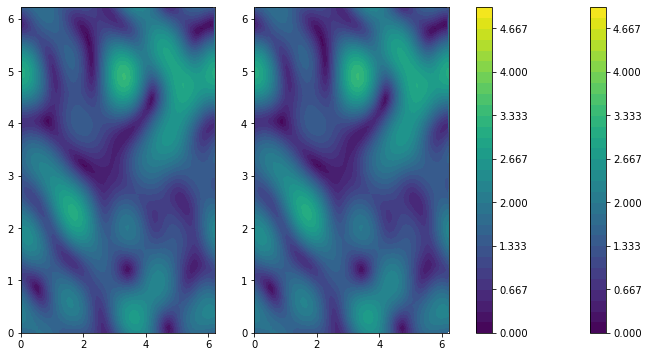

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

test case     1 | test loss: 0.037296190858
test case     2 | test loss: 0.023624718189
test case     3 | test loss: 0.029065230861
test case     4 | test loss: 0.038047935814
test case     5 | test loss: 0.022278245538
test case     6 | test loss: 0.037421971560
test case     7 | test loss: 0.032148726285
test case     8 | test loss: 0.018395436928
test case     9 | test loss: 0.020301716402


In [31]:
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
Config = namedtuple(
    "Config", 
    [
        "d", "hs_1", "hs_2", "method", "rtol", 
        "atol", "device", "model_path", "data_path"
    ]
)

args = Config(
    d=40,
    hs_1=60,
    hs_2=0,
    method="adaptive_heun",  # adams
    rtol=0.0,
    atol=1.0e-5,  # 1.0e-7
    device="cuda",
    model_path="./models/model_tmp.pth",
    data_path="./data/burgers/burgers_periodic_2pi_test/",
)

device = torch.device(args.device)

msg_net = nn.Sequential(
    nn.Linear(6, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.d)
)
aggr_net = nn.Sequential(
    nn.Linear(args.d+2, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, args.hs_1), nn.Tanh(), 
    nn.Linear(args.hs_1, 2)
)

model = Model(aggr_net, msg_net)
F = DynamicsFunction(model).to(device)
F.load_state_dict(torch.load(args.model_path, map_location=device))

data = read_pickle(['t', 'x', 'u'], args.data_path)
dataset = generate_torchgeom_dataset(data)
loader = DataLoader(dataset, batch_size=1, shuffle=False)

# Loss
loss_fn = nn.MSELoss()

# Testing
diffs_over_time = []
losses = torch.zeros(len(loader))

inds_of_sims_to_show = set([0])

with torch.no_grad():
    for i, dp in enumerate(loader):
        edge_index = dp.edge_index
        pos = dp.pos
        rel_pos = pos[edge_index[1]] - pos[edge_index[0]]
        params_dict = {'edge_index': edge_index.to(device), 'rel_pos': rel_pos.to(device)}
        F.update_params(params_dict)

        y0 = dp.x.to(device)
        t = dp.t.to(device)
        y_pd = odeint(
            F, y0, t, 
            method=args.method, 
            rtol=args.rtol, atol=args.atol,
            options={'dtype': torch.float64})
        y_gt = dp.y.transpose(0, 1).to(device)
        
        loss = loss_fn(y_pd, y_gt)
        losses[i] = loss.item()

        u = ((y_gt.cpu().detach().numpy()**2).sum(axis=2))**0.5
        u_pd = ((y_pd.cpu().detach().numpy()**2).sum(axis=2))**0.5
        u_mean = u.mean(axis=1).reshape(-1)
        
        eps = 1.0e-6
        diffs = [np.linalg.norm(u[i].reshape(-1) - u_pd[i].reshape(-1)) / (np.linalg.norm(u[i].reshape(-1)) + eps) for i in range(len(u))]
        diffs_over_time.append(diffs)

        print("test case {:>5d} | test loss: {:>7.12f}".format(i, losses[i]))

        if i in inds_of_sims_to_show:
            print("Plotting...")
            # utils.plot_grid(dataset[i].pos.cpu().detach().numpy())
            plt.figure(0)
            plot_fields(
                t=dataset[i].t,
                coords=dataset[i].pos,
                fields={
                    "y_pd": u_pd,
                    "y_gt": u,
                },
                save_path="tmp_figs/",
                delay=0.0001,
            )
            plt.show()

        # if i == 2:
        #     break


Plotting diffs...
diffs_over_time.shape (10, 61)
diffs_over_time.mean 0.18211936739035303
diffs_over_time.mean [0.         0.02948872 0.04504721 0.05713656 0.06714902 0.07580341
 0.08349071 0.09060813 0.09740376 0.10385845 0.10988704 0.115574
 0.12091552 0.12603613 0.1308883  0.1356169  0.14024521 0.14455871
 0.1484409  0.15206642 0.15536102 0.15846078 0.1615058  0.16460554
 0.16774679 0.17091575 0.17411953 0.1773679  0.18071633 0.18418306
 0.18774338 0.19138216 0.19506786 0.19876976 0.20248184 0.20620669
 0.20991203 0.21356497 0.21719862 0.2207914  0.22434766 0.22788684
 0.23139633 0.23485356 0.23823952 0.24154279 0.24476068 0.24788527
 0.25094276 0.25397529 0.25700744 0.26006469 0.26316243 0.26629748
 0.26946918 0.27267191 0.27590802 0.27917684 0.28247702 0.28579248
 0.28910689]


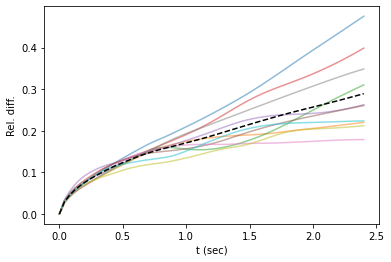

In [32]:
print("Plotting diffs...")
plt.figure(0)
t = dataset[0].t.numpy()

for diff in diffs_over_time:
    plt.plot(t, diff, alpha=0.5)

plt.plot(t, np.mean(diffs_over_time, axis=0), '--k')

plt.ylabel("Rel. diff.")
plt.xlabel("t (sec)")

# plt.show()
plt.savefig("diffs.png")

diffs_over_time = np.array(diffs_over_time)
print("diffs_over_time.shape", diffs_over_time.shape)
print("diffs_over_time.mean", diffs_over_time.mean())
print("diffs_over_time.mean", diffs_over_time.mean(axis=0))